In [19]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import emoji
import nltk

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from scipy.sparse import hstack
from scipy import sparse
import joblib

In [3]:
df_train = pd.read_csv('train 15 emoji.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test 15 emoji.csv')
df_test = pd.DataFrame(df_test)

In [4]:
def sentiment_scores(sentence):
 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict

In [5]:
df_train['vader_scores'] = df_train['content'].apply(sentiment_scores)
df_train['pos'] = df_train['vader_scores'].apply(lambda x: x['pos'])
df_train['neg'] = df_train['vader_scores'].apply(lambda x: x['neg'])
df_train['neu'] = df_train['vader_scores'].apply(lambda x: x['neu'])
df_train['compound'] = df_train['vader_scores'].apply(lambda x: x['compound'])

In [6]:
df_test['vader_scores'] = df_test['content'].apply(sentiment_scores)
df_test['pos'] = df_test['vader_scores'].apply(lambda x: x['pos'])
df_test['neg'] = df_test['vader_scores'].apply(lambda x: x['neg'])
df_test['neu'] = df_test['vader_scores'].apply(lambda x: x['neu'])
df_test['compound'] = df_test['vader_scores'].apply(lambda x: x['compound'])

In [7]:
vectorizer = TfidfVectorizer(sublinear_tf = True, use_idf = True)

X_train = vectorizer.fit_transform(df_train['cleaned_content'])
vader_features_train = sparse.coo_matrix(np.array(df_train[['pos', 'neg', 'neu', 'compound']].values))
X_train = sparse.hstack((X_train, vader_features_train))
y_train = df_train['emoji_id']

X_test = vectorizer.transform(df_test['cleaned_content'])
vader_features_test = sparse.coo_matrix(np.array(df_test[['pos', 'neg', 'neu', 'compound']].values))
X_test = sparse.hstack((X_test, vader_features_test))
y_test = df_test['emoji_id']

In [8]:
def top_k_prediction(prob, k):
    results = []
    for item in prob:
        # Create a copy of the original array to avoid modifying it
        arr_copy = item.copy()

        # Get the indices that would sort the array in ascending order
        sorted_indices = np.argsort(arr_copy)

        # Take the last 5 indices to get the indices of the top 5 elements
        top_indices = sorted_indices[-k:]
        
        results.append(top_indices)
        
    return results

In [9]:
def accuracy_by_emoji(df, is_acc_col):
    output = {}
    for i in range(15):
        output[i] = len(df[(df[is_acc_col] == 1) & (df['emoji_id'] == i)]) / len(df[df['emoji_id'] == i])
    output['overall'] = len(df[df[is_acc_col] == 1]) / len(df)
    return output

In [10]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_test_prob_pred_LR = LR.predict_proba(X_test)
df_test['pred_emoji_LR'] = top_k_prediction(y_test_prob_pred_LR, 3)
df_test['is_accurate_LR'] = df_test.apply(lambda x: x.emoji_id in x.pred_emoji_LR, axis=1)

y_train_prob_pred_LR = LR.predict_proba(X_train)
df_train['pred_emoji_LR'] = top_k_prediction(y_train_prob_pred_LR, 3)
df_train['is_accurate_LR'] = df_train.apply(lambda x: x.emoji_id in x.pred_emoji_LR, axis=1)

LR_acc_train = pd.DataFrame.from_dict(accuracy_by_emoji(df_train, 'is_accurate_LR'), orient='index')
LR_acc_test = pd.DataFrame.from_dict(accuracy_by_emoji(df_test, 'is_accurate_LR'), orient='index')
LR_acc = pd.merge(LR_acc_train, LR_acc_test, left_index=True, right_index=True)
LR_acc.columns = ['LR train', 'LR test']
LR_acc

,LR train,LR test
0,0.898871,0.858135
1,0.695859,0.617875
2,0.920023,0.895208
3,0.762489,0.679627
4,0.941651,0.910481
5,0.878893,0.836509
6,0.770117,0.697602
7,0.849390,0.806640
8,0.917412,0.900000
9,0.799619,0.730005


# Logistic Regression

In [20]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_test_prob_pred_LR = LR.predict_proba(X_test)
df_test['pred_emoji_LR'] = top_k_prediction(y_test_prob_pred_LR, 3)
df_test['is_accurate_LR'] = df_test.apply(lambda x: x.emoji_id in x.pred_emoji_LR, axis=1)a

y_train_prob_pred_LR = LR.predict_proba(X_train)
df_train['pred_emoji_LR'] = top_k_prediction(y_train_prob_pred_LR, 3)
df_train['is_accurate_LR'] = df_train.apply(lambda x: x.emoji_id in x.pred_emoji_LR, axis=1)

LR_acc_train = pd.DataFrame.from_dict(accuracy_by_emoji(df_train, 'is_accurate_LR'), orient='index')
LR_acc_test = pd.DataFrame.from_dict(accuracy_by_emoji(df_test, 'is_accurate_LR'), orient='index')
LR_acc = pd.merge(LR_acc_train, LR_acc_test, left_index=True, right_index=True)
LR_acc.columns = ['LR train', 'LR test']
LR_acc

,LR train,LR test
0,0.898871,0.858135
1,0.695859,0.617875
2,0.920023,0.895208
3,0.762489,0.679627
4,0.941651,0.910481
5,0.878893,0.836509
6,0.770117,0.697602
7,0.849390,0.806640
8,0.917412,0.900000
9,0.799619,0.730005


In [14]:
XGB_file = 'XGB.pkl'
joblib.dump(XGB, XGB_file)
XGB = joblib.load(XGB_file)

### Emoji-level analysis

In [23]:
test_Y=y_test
test_Y_pred= LR.predict(X_test)
test_df = pd.read_csv('test 15 emoji.csv')
predictions_prob = y_test_prob_pred_LR

              precision    recall  f1-score   support

           0       0.53      0.64      0.58      4462
           1       0.38      0.28      0.32      4386
           2       0.71      0.69      0.70      4466
           3       0.37      0.31      0.34      4501
           4       0.52      0.71      0.60      4513
           5       0.49      0.46      0.48      4514
           6       0.43      0.43      0.43      4504
           7       0.54      0.54      0.54      4458
           8       0.62      0.68      0.65      4370
           9       0.54      0.51      0.52      4426
          10       0.45      0.56      0.50      4468
          11       0.58      0.57      0.58      4508
          12       0.52      0.45      0.49      4532
          13       0.43      0.37      0.40      4452
          14       0.51      0.48      0.49      4571

    accuracy                           0.51     67131
   macro avg       0.51      0.51      0.51     67131
weighted avg       0.51   

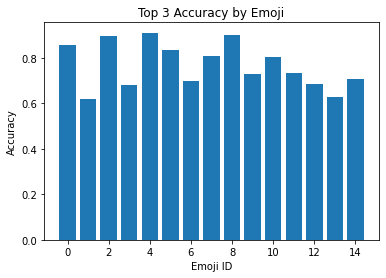

In [24]:
# Model Evaluation

from sklearn.metrics import classification_report
print(classification_report(test_Y, test_Y_pred))

# Emoji Recommender Top k Evaluation

def top_k_prediction(prob, k):
    results = []
    for item in prob:
        # Create a copy of the original array to avoid modifying it
        arr_copy = item.copy()

        # Get the indices that would sort the array in ascending order
        sorted_indices = np.argsort(arr_copy)

        # Take the last 5 indices to get the indices of the top 5 elements
        top_indices = sorted_indices[-k:]
        
        results.append(top_indices)
        
    return results

result = test_df.copy()

top_3_predictions = top_k_prediction(predictions_prob, 3)
result["predict_emoji_3"] = top_3_predictions
result["predict_accurate_3"] = result.apply(lambda x: x.emoji_id in x.predict_emoji_3, axis = 1)

# Top 3 accuracy - overall score
print(len(result[result["predict_accurate_3"] == 1]) / len(result))

result["count"] = 1
result_top_3_aggregated = pd.DataFrame()
result_top_3_aggregated["emoji_id"] = result.groupby("emoji_id")['predict_accurate_3'].sum().index.astype('str')
result_top_3_aggregated["count"] = result.groupby("emoji_id")['count'].sum().values
result_top_3_aggregated["accurate predictions"] = result.groupby("emoji_id")['predict_accurate_3'].sum().values
result_top_3_aggregated = result_top_3_aggregated.sort_values('accurate predictions', ascending = False)
result_top_3_aggregated["accuracy"] = result_top_3_aggregated["accurate predictions"] / result_top_3_aggregated["count"]
result_top_3_aggregated["emoji_id"] = pd.to_numeric(result_top_3_aggregated["emoji_id"])
result_top_3_aggregated = result_top_3_aggregated.sort_values(by=['emoji_id'])
result_top_3_aggregated

import matplotlib.pyplot as plt

x = result_top_3_aggregated["emoji_id"]
y = result_top_3_aggregated["accuracy"]

# Create the bar chart using the bar function
plt.bar(x, y)

# Add a title and axis labels
plt.title('Top 3 Accuracy by Emoji')
plt.xlabel('Emoji ID')
plt.ylabel('Accuracy')

# Display the plot
plt.show()



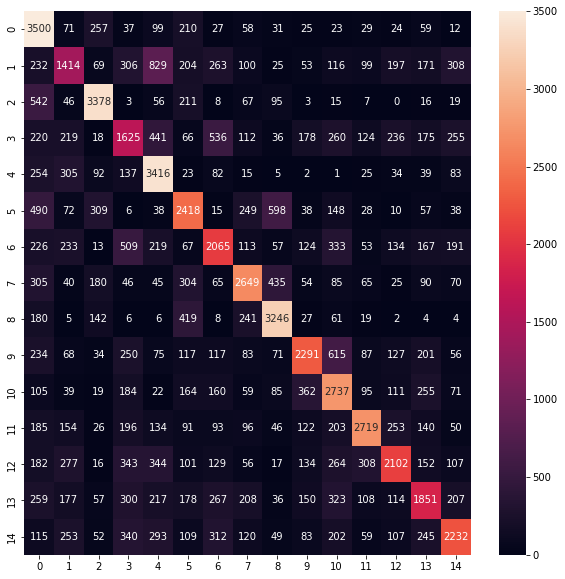

In [36]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(test_Y, test_Y_pred))
import seaborn as sn
plt.figure(figsize = (10, 10))
sn.heatmap(df_cm, annot = True, fmt = 'd')
plt.show()